In [1]:
import os
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer, AutoTokenizer


In [5]:
def eval(opt, checkpoint_path, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, opt.model_type)(
                num_classes=opt.num_classes,
                num_attention_head=opt.num_attention_head,
                dropout=opt.dropout,
                text_encoder_type=opt.text_encoder_type,
                text_encoder_dim=opt.text_encoder_dim,
                text_unfreeze=opt.text_unfreeze,
                audio_encoder_type=opt.audio_encoder_type,
                audio_encoder_dim=opt.audio_encoder_dim,
                audio_unfreeze=opt.audio_unfreeze,
                audio_norm_type=opt.audio_norm_type,
                fusion_head_output_type=opt.fusion_head_output_type,
            )
    network.to(device)

    # Build dataset
    _, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    # Load checkpoint with save_all_states = False
    # network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)).state_dict())
    # Load checkpoint with save_all_states = True
    network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device))["state_dict_backbone"])
    network.eval()
    network.to(device)

    y_actu=[]
    y_pred=[]

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label,am,ve = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        am = am.to(device)
        with torch.no_grad():
            output = network(input_ids,audio, attention_mask=am)[0]
            _, preds = torch.max(output, 1)
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds.detach().cpu().numpy()[0])
    print(accuracy_score(y_actu, y_pred))
    wa = balanced_accuracy_score(y_actu, y_pred)
    ua = accuracy_score(y_actu, y_pred)
    print("Balanced Accuracy: ", wa)
    print("Accuracy: ", ua)
    cm = confusion_matrix(y_actu, y_pred)
    print(cm)
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
    print (cmn)
# Create a figure and axis
    fig, ax = plt.subplots()

# Create a heatmap
    cax = ax.matshow(cmn, cmap='Blues')

# Add color bar
    plt.colorbar(cax)

# Set labels for x and y axes
    plt.xlabel('Predicted')
    plt.ylabel('True')

# Set x and y axis ticks
    plt.xticks(np.arange(4), ["Anger", "Happiness", "Sadness", "Neutral"])
    plt.yticks(np.arange(4), ["Anger", "Happiness", "Sadness", "Neutral"])

# Display the values in each cell
    for i in range(4):
        for j in range(4):
            plt.text(j, i, format(cmn[i, j], '.2f'),
                 ha='center', va='center', color='black', fontsize=12)

# Show the plot
    plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 679/679 [01:17<00:00,  8.74it/s]


0.6273932253313697
Balanced Accuracy:  0.5243490135004215
Accuracy:  0.6273932253313697
[[ 36  31   6  41]
 [ 12 110   5  66]
 [  4  11  28  38]
 [  5  25   9 252]]
[[31.57894737 27.19298246  5.26315789 35.96491228]
 [ 6.21761658 56.99481865  2.59067358 34.19689119]
 [ 4.9382716  13.58024691 34.56790123 46.91358025]
 [ 1.71821306  8.59106529  3.09278351 86.59793814]]


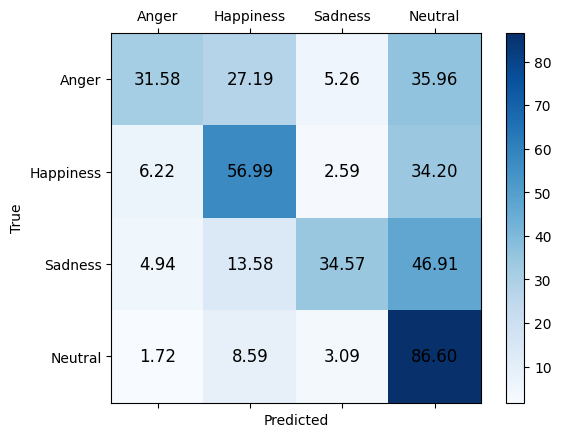

In [6]:
from configs.bert_vggish import Config as roberta_wav2vec2_config

checkpoint_path = "D:\MMSERA/notebooks\checkpoints/bert_vggish_MMSERA/20231013-090144" #check point
opt_path = os.path.join(checkpoint_path,"opt.log")
with open(opt_path, "r") as f:
    data = f.read().split("\n")
    # remove all empty strings
    data = list(filter(None, data))
    # convert to dict
    data_dict ={}
    for i in range(len(data)):
        key, value = data[i].split(":")[0].strip(), data[i].split(":")[1].strip()
        if '.' in value and value.replace('.', '').isdigit():
            value = float(value)
        elif value.isdigit():
            value = int(value)
        elif value == 'True':
            value = True
        elif value == 'False':
            value = False
        elif value == 'None':
            value = None
        data_dict[key] = value
# Load checkpoint with save_all_states = False
ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0_0.pt")
# Load checkpoint with save_all_states = False
# ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0.pt")
opt = roberta_wav2vec2_config()
# Replace the default config with the loaded config
for key, value in data_dict.items():
    setattr(opt, key, value)
    
# Set dataset path
opt.data_root="D:\MELD\MELD"

tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
eval(opt, ckpt_path, tokenizer)

In [7]:
def f1_score_from_confusion_matrix(confusion_matrix):
    # Extract true positives for each class
    tp = np.diag(confusion_matrix)
    
    # Calculate false positives for each class
    fp = np.sum(confusion_matrix, axis=0) - tp
    
    # Calculate false negatives for each class
    fn = np.sum(confusion_matrix, axis=1) - tp
    
    # Calculate precision and recall for each class with checks for division by zero
    precision = np.where(tp + fp == 0, 0, tp / (tp + fp))
    recall = np.where(tp + fn == 0, 0, tp / (tp + fn))
    
    # Macro-average F1 score
    f1_macro = np.mean(2 * precision * recall / (precision + recall + 1e-10))  # added a small value to avoid division by zero
    
    # Micro-average F1 score
    sum_tp = np.sum(tp)
    sum_fp = np.sum(fp)
    sum_fn = np.sum(fn)
    precision_micro = sum_tp / (sum_tp + sum_fp)
    recall_micro = sum_tp / (sum_tp + sum_fn)
    f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro)
    
    return f1_macro, f1_micro

# Given 4-class confusion matrix
confusion_matrix = np.array([
    [ 36,  31,   6,  41],
    [ 12, 110,   5,  66],
    [  4,  11,  28,  38],
    [  5,  25,   9, 252]
])

f1_macro, f1_micro = f1_score_from_confusion_matrix(confusion_matrix)
print(f"Macro-average F1 score: {f1_macro:.4f}")
print(f"Micro-average F1 score: {f1_micro:.4f}")


Macro-average F1 score: 0.5456
Micro-average F1 score: 0.6274
